In [1]:
import numpy as np
import scipy as sp
import scipy.signal
import cv2
import matplotlib.pyplot as plt
import math


In [2]:

def generatingKernel(parameter):
    """ Return a 5x5 generating kernel based on an input parameter.
    Note: This function is provided for you, do not change it.
    Args:
      parameter (float): Range of value: [0, 1].
    Returns:
      numpy.ndarray: A 5x5 kernel.
    """
    kernel = np.array([0.25 - parameter / 2.0, 0.25, parameter,
                       0.25, 0.25 - parameter / 2.0])
    return np.outer(kernel, kernel)



In [3]:

def reduce(image):
    """ Convolve the input image with a generating kernel of parameter of 0.4 and
    then reduce its width and height by two.
    Please consult the lectures and readme for a more in-depth discussion of how
    to tackle the reduce function.
    You can use any / all functions to convolve and reduce the image, although
    the lectures have recommended methods that we advise since there are a lot
    of pieces to this assignment that need to work 'just right'.
    Args:
      image (numpy.ndarray): a grayscale image of shape (r, c)
    Returns:
      output (numpy.ndarray): an image of shape (ceil(r/2), ceil(c/2))
        For instance, if the input is 5x7, the output will be 3x4.
    """
    return scipy.signal.convolve2d(image, generatingKernel(0.4), 'same')[::2, ::2]



In [4]:

def expand(image):
    """ Expand the image to double the size and then convolve it with a generating
    kernel with a parameter of 0.4.
    You should upsample the image, and then convolve it with a generating kernel
    of a = 0.4.
    Finally, multiply your output image by a factor of 4 in order to scale it
    back up. If you do not do this (and I recommend you try it out without that)
    you will see that your images darken as you apply the convolution. Please
    explain why this happens in your submission PDF.
    Please consult the lectures and readme for a more in-depth discussion of how
    to tackle the expand function.
    You can use any / all functions to convolve and reduce the image, although
    the lectures have recommended methods that we advise since there are a lot
    of pieces to this assignment that need to work 'just right'.
    Args:
      image (numpy.ndarray): a grayscale image of shape (r, c)
    Returns:
      output (numpy.ndarray): an image of shape (2*r, 2*c)
    """
    (width, height) = image.shape
    newimage = np.zeros([width * 2, height * 2])
    newimage[::2, ::2] = image
    return scipy.signal.convolve2d(newimage, generatingKernel(0.4), 'same') * 4




In [5]:

def gaussPyramid(image, levels):
    """ Construct a pyramid from the image by reducing it by the number of levels
    passed in by the input.
    Note: You need to use your reduce function in this function to generate the
    output.
    Args:
      image (numpy.ndarray): A grayscale image of dimension (r,c) and dtype float.
      levels (uint8): A positive integer that specifies the number of reductions
                      you should do. So, if levels = 0, you should return a list
                      containing just the input image. If levels = 1, you should
                      do one reduction. len(output) = levels + 1
    Returns:
      output (list): A list of arrays of dtype np.float. The first element of the
                     list (output[0]) is layer 0 of the pyramid (the image
                     itself). output[1] is layer 1 of the pyramid (image reduced
                     once), etc. We have already included the original image in
                     the output array for you. The arrays are of type
                     numpy.ndarray.
    """
    output = [image]
    for i in range(levels):
        output.append(reduce(output[i]))
        
    return output



In [6]:

def laplPyramid(gaussPyr):
    """ Construct a laplacian pyramid from the gaussian pyramid, of height levels.
    Note: You must use your expand function in this function to generate the
    output. The Gaussian Pyramid that is passed in is the output of your
    gaussPyramid function.
    Args:
      gaussPyr (list): A Gaussian Pyramid as returned by your gaussPyramid
                       function. It is a list of numpy.ndarray items.
    Returns:
      output (list): A laplacian pyramid of the same size as gaussPyr. This
                     pyramid should be represented in the same way as guassPyr,
                     as a list of arrays. Every element of the list now
                     corresponds to a layer of the laplacian pyramid, containing
                     the difference between two layers of the gaussian pyramid.
             output[k] = gauss_pyr[k] - expand(gauss_pyr[k + 1])
             Note: The last element of output should be identical to the last
             layer of the input pyramid since it cannot be subtracted anymore.
    Note: Sometimes the size of the expanded image will be larger than the given
    layer. You should crop the expanded image to match in shape with the given
    layer.
    For example, if my layer is of size 5x7, reducing and expanding will result
    in an image of size 6x8. In this case, crop the expanded layer to 5x7 by
    removing the last row/column.
    """
    output = []
    
    for i in range(len(gaussPyr) - 1):
        (width, height) = gaussPyr[i].shape
        output.append(gaussPyr[i] - expand(gaussPyr[i+1])[:width,:height])
    output.append(gaussPyr[len(gaussPyr) - 1])

    return output



In [7]:

def blend(laplPyrWhite, laplPyrBlack, gaussPyrMask):
    """ Blend the two laplacian pyramids by weighting them according to the
    gaussian mask.
    Args:
      laplPyrWhite (list): A laplacian pyramid of one image, as constructed by
                           your laplPyramid function.
      laplPyrBlack (list): A laplacian pyramid of another image, as constructed by
                           your laplPyramid function.
      gaussPyrMask (list): A gaussian pyramid of the mask. Each value is in the
                           range of [0, 1].
    The pyramids will have the same number of levels. Furthermore, each layer
    is guaranteed to have the same shape as previous levels.
    You should return a laplacian pyramid that is of the same dimensions as the
    input pyramids. Every layer should be an alpha blend of the corresponding
    layers of the input pyramids, weighted by the gaussian mask. This means the
    following computation for each layer of the pyramid:
      output[i, j] = current_mask[i, j] * white_image[i, j] +
                     (1 - current_mask[i, j]) * black_image[i, j]
    Therefore:
      Pixels where current_mask == 1 should be taken completely from the white
      image.
      Pixels where current_mask == 0 should be taken completely from the black
      image.
    Note: current_mask, white_image, and black_image are variables that refer to
    the image in the current layer we are looking at. You do this computation for
    every layer of the pyramid.
    """
    blended_pyr = []

    for level in range(len(laplPyrBlack)):
        newlevel = laplPyrBlack[level] * (1 - gaussPyrMask[level]) + laplPyrWhite[level] * gaussPyrMask[level]
        blended_pyr.append(newlevel)

    return blended_pyr
   



In [8]:

def collapse(pyramid):
    """ Collapse an input pyramid.
    Args:
      pyramid (list): A list of numpy.ndarray images. You can assume the input is
                    taken from blend() or laplPyramid().
    Returns:
      output(numpy.ndarray): An image of the same shape as the base layer of the
                             pyramid and dtype float.
    Approach this problem as follows, start at the smallest layer of the pyramid.
    Expand the smallest layer, and add it to the second to smallest layer. Then,
    expand the second to smallest layer, and continue the process until you are
    at the largest image. This is your result.
    Note: sometimes expand will return an image that is larger than the next
    layer. In this case, you should crop the expanded image down to the size of
    the next layer. Look into numpy slicing / read our README to do this easily.
    For example, expanding a layer of size 3x4 will result in an image of size
    6x8. If the next layer is of size 5x7, crop the expanded image to size 5x7
    by removing the last row/column.
    """

    output = pyramid[len(pyramid)-1]
    for i in range(len(pyramid) - 2, -1, -1):
        (width, height) = pyramid[i].shape
        output = expand(output)[:width, :height] + pyramid[i]

    return output

In [50]:
def run_blend(black_image, white_image, mask):
    """ This function administrates the blending of the two images according to 
    mask.
    Assume all images are float dtype, and return a float dtype.
    """

    # Automatically figure out the size
    min_size = min(black_image.shape)
    depth = int(math.floor(math.log(min_size, 2))) - 4 # at least 16x16 at the highest level.

    gauss_pyr_mask = gaussPyramid(mask, depth)
    gauss_pyr_black = gaussPyramid(black_image, depth)
    gauss_pyr_white = gaussPyramid(white_image, depth)
    lapl_pyr_black  = laplPyramid(gauss_pyr_black)
    lapl_pyr_white = laplPyramid(gauss_pyr_white)
    
    outpyr = blend(lapl_pyr_white, lapl_pyr_black, gauss_pyr_mask)
    outimg = collapse(outpyr)
    
    outimg[outimg < 0] = 0 # blending sometimes results in slightly out of bound numbers.
    outimg[outimg > 255] = 255
    outimg = outimg.astype(np.uint8)

    return outimg


In [51]:
black = cv2.cvtColor(cv2.imread("black.jpg"), cv2.COLOR_RGB2BGR).astype(float)
white = cv2.cvtColor(cv2.imread("white.jpg"), cv2.COLOR_RGB2BGR).astype(float)
mask = cv2.imread("mask.jpg").astype(float)/255

In [52]:
outimg = []
for channel in range(3):
      outimg.append(run_blend(black[:,:,channel], white[:,:,channel], mask[:,:,channel]))
outimg = cv2.merge(outimg)

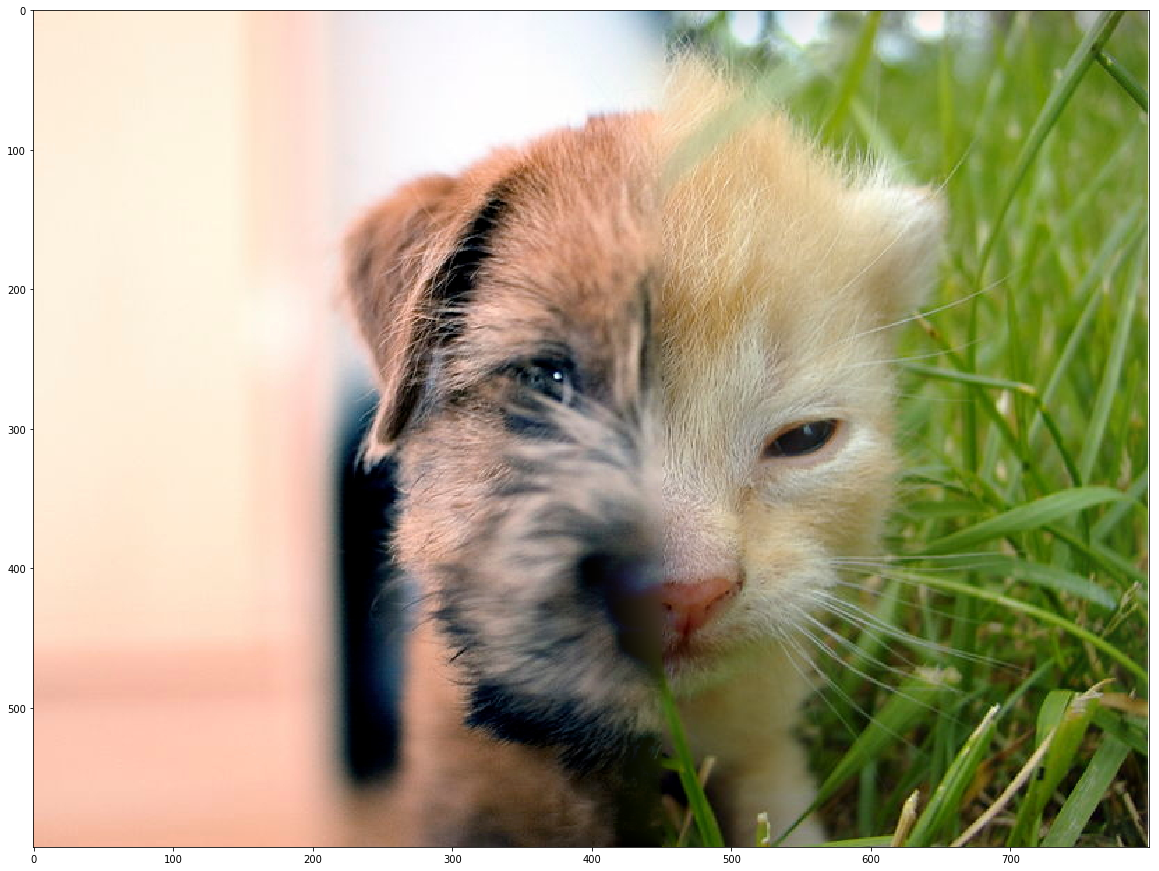

In [53]:
plt.figure(figsize=(20,20))
plt.imshow(outimg)